<a href="https://colab.research.google.com/github/trhgquan/CS156/blob/main/sentiment_analysis/danh_gia_mon_hoc_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Thông tin
Sinh viên thực hiện: Trần Hoàng Quân

MSSV: 19120338

GitHub: [@trhgquan](https://github.com/trhgquan)

# Ý tưởng

Em sẽ tiếp cận bài toán thông qua hướng text classification, dùng giải thuật Naive Bayes.

# Cài đặt các thư viện liên quan

Một số thư viện em sẽ sử dụng trong bài tập này bao gồm:
- underthesea của nhóm undertheseanlp, dùng để tách từ tiếng Việt từ một câu (word_tokenize).
- imbalanced-learn, dùng để xử lý dataset mất cân bằng.

In [1]:
%pip install underthesea
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.



In [2]:
import pandas as pd
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import joblib

from underthesea import word_tokenize
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import RandomOverSampler

# Tạo dataset & tiền xử lý dữ liệu

## 1. Giải nén file dataset

In [3]:
def extracting_file():
    with zipfile.ZipFile('UIT-VSFC.zip', 'r') as zfile:
        zfile.extractall('UIT-VSFC/')

extracting_file()

## 2. Lấy danh sách các stopwords

In [4]:
stopwords = []

with open('stopwords.txt', 'r+', encoding='utf-8') as f:
    for line in f:
        stopwords.append(line.strip())

print(len(stopwords))

1942


## 3. Định nghĩa các hàm hỗ trợ tiền xử lý dữ liệu

In [5]:
# Tạo pandas frame từ 2 list

def create_frame(sentences, labels):
    result = {
        'sentences': sentences,
        'labels': labels
    }
    return pd.DataFrame(result)

In [6]:
# Tiền xử lý: loại bỏ các dấu , . ! ?,
# loại bỏ dấu cách thừa và chuyển string về dạng lowercase.

def preprocess(sentence):
    sentence = sentence.strip()
    sentence = sentence.replace(',', '')
    sentence = sentence.replace('.', '')
    sentence = sentence.replace('?', '')
    sentence = sentence.replace('!', '')
    sentence = sentence.replace('"', '')
    sentence = sentence.replace('  ', ' ')
    return sentence.lower().strip()

## 4. Tạo dataset

In [7]:
train_sentences, train_labels = [], []

with open('UIT-VSFC/UIT-VSFC/train/sents.txt', 'r+', encoding = 'utf-8') as f:
    for line in f:
        train_sentences.append(preprocess(line))

with open('UIT-VSFC/UIT-VSFC/train/sentiments.txt', 'r+', encoding = 'utf-8') as f:
    for line in f:
        train_labels.append(int(line.strip()) - 1)

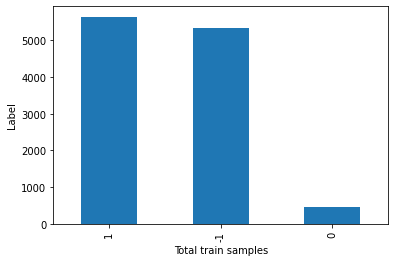

In [8]:
train_dataset = create_frame(train_sentences, train_labels)
count = train_dataset['labels'].value_counts()
count.plot.bar()
plt.ylabel('Label')
plt.xlabel('Total train samples')
plt.show()

In [9]:
test_sentences, test_labels = [], []

with open('UIT-VSFC/UIT-VSFC//test/sents.txt', 'r+', encoding = 'utf-8') as f:
    for line in f:
        test_sentences.append(preprocess(line))

with open('UIT-VSFC/UIT-VSFC/test/sentiments.txt', 'r+', encoding = 'utf-8') as f:
    for line in f:
        test_labels.append(int(line.strip()) - 1)

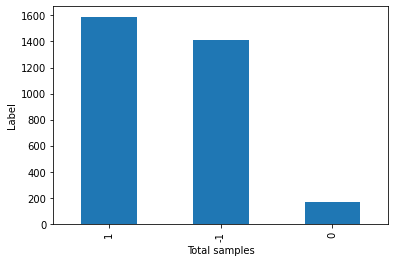

In [10]:
test_dataset = create_frame(test_sentences, test_labels)
test_dataset['labels'].value_counts()
count = test_dataset['labels'].value_counts()
count.plot.bar()
plt.ylabel('Label')
plt.xlabel('Total samples')
plt.show()


In [11]:
dev_sentences, dev_labels = [], []

with open('UIT-VSFC/UIT-VSFC/test/sents.txt', 'r+', encoding = 'utf-8') as f:
    for line in f:
        dev_sentences.append(preprocess(line))

with open('UIT-VSFC/UIT-VSFC/test/sentiments.txt', 'r+', encoding = 'utf-8') as f:
    for line in f:
        dev_labels.append(int(line.strip()) - 1)

# dev_dataset = create_frame(dev_sentences, dev_labels)

## Nhận xét nhanh
Qua các biểu đồ trên, ta dễ dàng nhận thấy dataset này không cân bằng: tỉ lệ label 0 (neutral) quá nhỏ so với các label còn lại.

Để giải quyết, ta sẽ sử dụng kĩ thuật Oversampling.

In [12]:
oversample = RandomOverSampler(sampling_strategy = 'minority')

# Train model

In [13]:
# Hàm tách từ, dùng word_tokenize của underthesea
def tokenize(sentence):
    return word_tokenize(sentence, format = 'word')

In [14]:
# Chuyển câu tiếng Việt về vector, sử dụng CountVectorizer của sklearn
# với các tham số là danh sách stopwords tiếng Việt 
# và tokenizer tách từ tiếng Việt

vectorizer = CountVectorizer(
    stop_words = stopwords,
    tokenizer = tokenize
)

In [15]:
X = vectorizer.fit_transform(train_sentences)
y = train_labels

X_test = vectorizer.transform(test_sentences)
y_test = test_labels

In [16]:
# Oversampling X và y là training dataset.
X_over, y_over = oversample.fit_resample(X, y)

In [17]:
# Dùng giải thuật Naive Bayes để train model.
model = MultinomialNB()
model.fit(X_over, y_over)

joblib.dump(model, 'sentiment.joblib')
joblib.dump(vectorizer, 'vectorizer.joblib')

['vectorizer.joblib']

In [18]:
# Load model
model_ = joblib.load('sentiment.joblib')
vectorizer_ = joblib.load('vectorizer.joblib')

In [19]:
# Model score.
print(model_.score(X_test, y_test))

0.7485786481364498


# Demo

In [20]:
sentences = [
    'Thầy dạy rất hay',
    'Không ai hướng dẫn, toàn phải tự lực cánh sinh',
    'Người lái đò sông Đà',
    'Thầy toàn đọc slide, không giảng bài',
    'Phí tiền khi học lớp này',
    'Anh hùng vũ trụ Phạm Tuân',
    'Cọc phí quá cao, cô lại dạy dở, không ai hỗ trợ',
    'Trợ giảng rất nhiệt tình',
    'Thầy tận tình giúp đỡ sinh viên',
    'Tuyên ngôn độc lập quảng trường Ba Đình'
]

for s in sentences:
    predict_ = model_.predict(vectorizer_.transform([preprocess(s)]))
    
    print(s, predict_[0])

Thầy dạy rất hay 1
Không ai hướng dẫn, toàn phải tự lực cánh sinh -1
Người lái đò sông Đà 0
Thầy toàn đọc slide, không giảng bài -1
Phí tiền khi học lớp này -1
Anh hùng vũ trụ Phạm Tuân 0
Cọc phí quá cao, cô lại dạy dở, không ai hỗ trợ -1
Trợ giảng rất nhiệt tình 1
Thầy tận tình giúp đỡ sinh viên 1
Tuyên ngôn độc lập quảng trường Ba Đình 0
